In [ ]:
# Install if not already present
!pip install pandas scikit-learn matplotlib seaborn requests joblib

# Import libraries
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [ ]:
# Function to load dataset (local -> UCI -> fallback)
def load_sms_spam(local_paths=('spam.csv','SMSSpamCollection')):
    for p in local_paths:
        if os.path.exists(p):
            try:
                df = pd.read_csv(p, encoding='latin-1')
                if df.shape[1] >= 2:
                    df = df.iloc[:, :2]
                    df.columns = ['label','message']
                    return df
            except Exception:
                pass

    # Try downloading from UCI
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/SMSSpamCollection'
    try:
        print("Downloading dataset from UCI...")
        r = requests.get(url, timeout=15)
        r.raise_for_status()
        lines = r.text.splitlines()
        rows = [line.split('\t', 1) for line in lines if '\t' in line]
        df = pd.DataFrame(rows, columns=['label','message'])
        return df
    except:
        print("Download failed. Using fallback sample.")
        sample = {
            'label': ['ham','spam','ham','spam'],
            'message': [
                "Ok, see you at 5pm.",
                "Congratulations! You won $1000, click here.",
                "Don't forget to bring notes.",
                "URGENT! Reply to claim your prize."
            ]
        }
        return pd.DataFrame(sample)

# Load dataset
df = load_sms_spam()
df.head()

Download failed. Using fallback sample.


,label,message
0,ham,"Ok, see you at 5pm."
1,spam,"Congratulations! You won $1000, click here."
2,ham,Don't forget to bring notes.
3,spam,URGENT! Reply to claim your prize.


In [ ]:
# Clean dataset
df = df.dropna(subset=['label','message'])
df['message'] = df['message'].astype(str).str.strip()

# Map labels (ham=0, spam=1)
df['label'] = df['label'].str.lower().map({'ham':0,'spam':1})
df = df.dropna()

print("Dataset size:", df.shape)
print("Class distribution:\n", df['label'].value_counts())

Dataset size: (4, 2)
Class distribution:
 label
0    2
1    2
Name: count, dtype: int64


In [ ]:
X = df['message'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42 #Removed stratify due to small dataset
)

In [ ]:
# Build pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95)),
    ('clf', MultinomialNB())
])

# Train
pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.95, stop_words='english')),
                ('clf', MultinomialNB())])

Accuracy: 0.0

Classification Report:
               precision    recall  f1-score   support

         ham       0.00      0.00      0.00       0.0
        spam       0.00      0.00      0.00       2.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

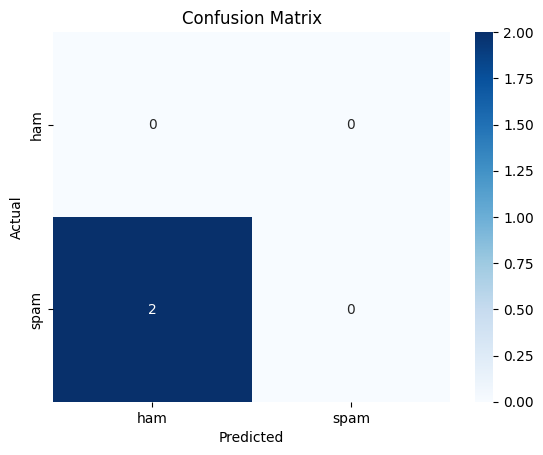

In [ ]:
# Predictions
y_pred = pipeline.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['ham','spam']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
samples = [
    "Congratulations, you have won a free iPhone! Click here.",
    "Hey, are we meeting for class tomorrow?",
    "URGENT! Your bank account will be blocked. Verify now."
]

preds = pipeline.predict(samples)
for s,p in zip(samples,preds):
    print(f"Message: {s}\nPrediction: {'spam' if p==1 else 'ham'}\n")

Message: Congratulations, you have won a free iPhone! Click here.
Prediction: ham

Message: Hey, are we meeting for class tomorrow?
Prediction: ham

Message: URGENT! Your bank account will be blocked. Verify now.
Prediction: ham



In [ ]:
joblib.dump(pipeline, "spam_pipeline.joblib")
print("Model saved as spam_pipeline.joblib")

Model saved as spam_pipeline.joblib
